In [255]:
import pandas as pd
import numpy as np
import datetime as datetime
import math
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from tqdm import tqdm
import random
from scipy.stats import ttest_ind
tqdm.pandas()

/Users/clemencebarsi/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [112]:
data_folder = './data/'

# Method returning the dataframe obtained from the csv file named "name".
def get_dataframe(name):
    return pd.read_csv(data_folder + name, compression='gzip', sep='\t',header = None)

b_edges = get_dataframe('loc-brightkite_edges.txt.gz')
brightkite_checkins = get_dataframe('loc-brightkite_totalCheckins.txt.gz')
g_edges = get_dataframe('loc-gowalla_edges.txt.gz')
gowalla_checkins = get_dataframe('loc-gowalla_totalCheckins.txt.gz')
countries = pd.read_csv(data_folder + 'countries.csv')


In [114]:
b_edges = b_edges.rename(columns = {0: 'user', 1:'friend'})
g_edges = g_edges.rename(columns = {0: 'user', 1:'friend'})


In [3]:
#Renaming the columns in the given dataframes with the names given.
b_checkins = brightkite_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})
g_checkins = gowalla_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})

#Checking the number of checkins we have in each dataframe.
print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))
b_checkins.head()

Number of checkins in Brightkite: 4747287
Number of checkins in Gowalla: 6442892


,user,checkin_time,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc


In [4]:
# Checking for rows with impossible longitudes/latitudes and removing them if needed.

b_checkins.drop(b_checkins[(b_checkins.latitude>90.0)|(b_checkins.latitude<-90.0)].index, inplace = True)
b_checkins.drop(b_checkins[(b_checkins.longitude>180.0)|(b_checkins.longitude<-180.0)].index, inplace = True)
b_checkins.drop(b_checkins[b_checkins['latitude'].isnull()].index, inplace=True)
b_checkins.drop(b_checkins[b_checkins['longitude'].isnull()].index, inplace=True)


#I noticed thousands of checkins at the location (0.0, 0.0) that corresponds to a spot in the Atlantic Ocean. I assumed it
#was an error in the system and simply chose to drop them
b_checkins = b_checkins[(b_checkins.longitude !=0)|(b_checkins.latitude!=0)]

#We drop in checkin_g the rows that contain null values in longitude and latitude, and latitudes above and below 90 and -90
#and longitudes above and below 180 and -180

g_checkins.drop(g_checkins[(g_checkins.latitude>90.0)|(g_checkins.latitude<-90.0)].index, inplace = True)
g_checkins.drop(g_checkins[(g_checkins.longitude>180.0)|(g_checkins.longitude<-180.0)].index, inplace = True)
g_checkins.drop(g_checkins[g_checkins['latitude'].isnull()].index, inplace=True)
g_checkins.drop(g_checkins[g_checkins['longitude'].isnull()].index, inplace=True)

#As for Brightkite there were thousands of checkins at the location (0.0, 0.0) that corresponds to a spot in the Atlantic 
#Ocean. I assumed it was also an error in the system and dropped
g_checkins = g_checkins[(g_checkins.longitude !=0)|(g_checkins.latitude!=0)]

print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))

Number of checkins in Brightkite: 4491035
Number of checkins in Gowalla: 6442728


NameError: name 'b_with_dist' is not defined

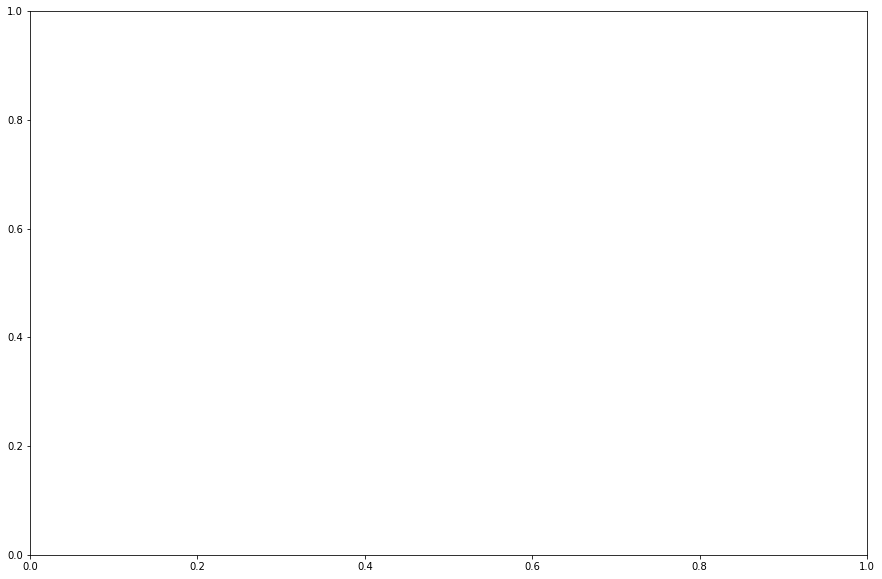

In [8]:
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(b_with_dist.longitude, b_with_dist.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(world_map, zorder=0, extent = BBox, aspect= 'equal')

In [ ]:
world_map = plt.imread('./Data/world_map4.png')
BBox = (g_with_dist.longitude.min(),g_with_dist.longitude.max(),g_with_dist.latitude.min(), g_with_dist.latitude.max())
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(g_with_dist.longitude, g_with_dist.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(world_map, zorder=0, extent = BBox, aspect= 'equal')

## Placing the checkins in the continents

In [5]:
countries = pd.read_csv(data_folder + 'countries.csv', sep = ';').copy()
countries.set_index('area', inplace = True)
countries.head()

,bottom_left_lat,bottom_left_long,top_right_lat,top_right_long
area,,,,
usa,24.539159,-125.325272,49.000000,-60.128423
western_europe,35.904000,-10.000000,59.128197,8.212485
east_asia,29.895673,125.792187,45.652509,145.745126


In [29]:
def is_in_country(row, country):
    country_lat_range = range(int(country['bottom_left_lat']), int(country['top_right_lat'])+1)
    country_long_range = range(int(country['bottom_left_long']), int(country['top_right_long'])+1)
    return (int(row['latitude']) in country_lat_range) & (int(row['longitude']) in country_long_range)

In [30]:
b_checkins['is_in_usa'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)
g_checkins['is_in_usa'] = g_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)

#b_checkins.head()

100%|██████████| 6442727/6442727 [24:11<00:00, 4437.52it/s]  


In [31]:
b_checkins['is_in_europe'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)
g_checkins['is_in_europe'] = g_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)

#b_checkins.head()

100%|██████████| 6442727/6442727 [24:13<00:00, 4432.04it/s]


In [32]:
b_checkins['is_in_asia'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)
g_checkins['is_in_asia'] = g_checkins.progress_apply(lambda row: is_in_country(row,countries.loc['east_asia']), axis=1)

#b_checkins.head()

100%|██████████| 6442727/6442727 [18:05:49<00:00, 98.89it/s]      


In [38]:
print('Brightkite in USA ' + str(len(b_checkins[b_checkins['is_in_usa']])))
print('Brightkite in Europe ' + str(len(b_checkins[b_checkins['is_in_europe']])))
print('Brightkite in Japan ' + str(len(b_checkins[b_checkins['is_in_asia']])))


Brightkite in USA 2923138
Brightkite in Europe 45972
Brightkite in Japan 422944


In [40]:
print('Gowalla in USA ' + str(len(g_checkins[g_checkins['is_in_usa']])))
print('Gowalla in Europe ' + str(len(g_checkins[g_checkins['is_in_europe']])))
print('Gowalla in Japan ' + str(len(g_checkins[g_checkins['is_in_asia']])))


Gowalla in USA 3675793
Gowalla in Europe 60913
Gowalla in Japan 66734


In [41]:
b_checkins = b_checkins[b_checkins['is_in_europe'] | b_checkins['is_in_usa'] | b_checkins['is_in_asia']]
g_checkins = g_checkins[g_checkins['is_in_europe'] | g_checkins['is_in_usa'] | g_checkins['is_in_asia']]

In [42]:
print(len(b_checkins))
print(len(g_checkins))

3392054
3803440


#### Interprétation:

je pense que faire ensuite un texte sur le fait que va y avoir des checkins qui vont correspondre à deux pays mais que c’est pas trop grave parce que ça veut dire que c’est des zones limitrophes et donc que elles ont potentiellement des influences culturelles des deux pays, particulierement en europe c’est pas mal nan?

In [43]:
b_checkins.to_csv(r'./data/b_checkins_with_countries.csv', compression='gzip')
g_checkins.to_csv(r'./data/g_checkins_with_countries.csv', compression='gzip')

In [6]:
b_checkins = pd.read_csv('Data/b_checkins_with_countries.csv', compression = 'gzip')
g_checkins = pd.read_csv('Data/g_checkins_with_countries.csv', compression = 'gzip')

Finding the homes of the users and classifying them in each continent

## Making the conversions

We create the different functions and constants needed for assigning the locations to cells.
The function get_cell_coordinates gives the wanted coordinates of the cell given the latitude and longitude.

In [7]:
#lat_deg_in_km is the coefficient of conversion of a latitude in degrees to latitude in kilometers
#side_of_square is the size of the side of the cells in the discretized world in kilometers
#long_deg_in_km is the constant coefficient of conversion of a longitude in degrees to kilometers

lat_deg_in_km = 110.574
side_of_square = 25
long_deg_in_km = 111.3290

In [8]:
#the function long_deg_to_km returns the total coefficent of conversion of a longitude in degrees to kilometers in function 
#of the latitude and long_deg_in_km
def long_deg_to_km(lat):
    return long_deg_in_km*np.cos(lat)


#get_cell_coordinates obtains the coordinates in the discretized world (squares of 25 by 25 km) from a location in
#latitude and longitude, we simply multiply the latitude by lat_deg_in_km and divide it by side_of_square
#and multiply the longitude by long_deg_to_km(lat) and divide it by side_of_square
def get_cell_coordinates(lat, long):
    x_coord = int((long*long_deg_to_km(lat))/side_of_square)
    y_coord = int((lat*lat_deg_in_km)/side_of_square)
    return (x_coord, y_coord)

## Assigning cells

Now we can assign to the locations the corresponding coordinates in the discrertized world. We simply add a new column in each checkin dataframe and apply to it the previously made get_cell_coordinates function.

In [46]:
#we add a new column to the dataframe checkin_b. This column(named cell_coord) contains the coordinates of the checkins
#in the discretized world. We obtain it by simply applying the function get_cell_coordinates to each row
b_checkins['cell_coord'] = b_checkins.progress_apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)
g_checkins['cell_coord'] = g_checkins.progress_apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)


## 3. Finding the homes of the users

We now want to find the home of each user. It is assumed that it is the cell that has the most checkins of this user. If there are several cells with the maximum number of checkins, I just kept the one that appeared first in the Dataframe. If there are two cells that have the maximum number of checkins, this is probably because one is the home and the other the worlplace.

In [47]:
#This function finds the homes of the users given a dataframe containing all the checkins(with columns : user,
#cell_coords, latitudes and longitudes)

def finding_homes(df):
    
    #We insert a column count (that for the moment countains only ones) in the dataframe that will contain how many 
    #checkins were made by a user in a cell_coord
    df.insert(0, "count", [1]*df.shape[0], True)
    
    #To count the number of checkins, we do a groupby on user and cell_coord. We count the number of checkins in each
    #groupby, and to obtain the latitude and longitude of checkins in this cell, we do a mean of all latitudes and
    #longitudes that are in this cell. We drop the rows with NaNs in them and reset the index for convenience
    df = df.groupby(['user', 'cell_coord']).agg({'count' : 'count', 'latitude' : 'mean', 'longitude':'mean'})
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace = True)
    
    #We sort the values by descending order in count, so that the cells with the most count are at the top for each user
    df.sort_values(by = 'count', ascending=False, inplace = True)
    
    #We drop the duplicates of user to keep only the cell with the biggest count as it is at the top. For convenience
    #we set user as the index sorted by ascending order
    df.drop_duplicates(subset = 'user', keep= 'first', inplace=True)
    df.sort_values(by='user', inplace=True)
    df.set_index('user', inplace = True)
    return df

In [48]:
#We call the function finding_homes on the checkins in Brightkite

homes_in_b = b_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_b = finding_homes(homes_in_b)
homes_in_b.reset_index(inplace = True)
homes_in_b.head()

,user,cell_coord,count,latitude,longitude
0,0,"(272, 176)",229,39.891261,-105.068678
1,1,"(-543, 166)",357,37.628486,-122.419079
2,2,"(211, 175)",305,39.739295,-104.982155
3,3,"(-543, 167)",549,37.777024,-122.404865
4,4,"(-543, 167)",131,37.779107,-122.410060


In [49]:
homes_in_g = g_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_g = finding_homes(homes_in_g)
homes_in_g.reset_index(inplace = True)
homes_in_g.head()

,user,cell_coord,count,latitude,longitude
0,0,"(-179, 133)",35,30.269307,-97.749469
1,2,"(-536, 167)",317,37.869730,-122.260862
2,4,"(-543, 167)",94,37.783623,-122.409399
3,5,"(-183, 133)",11,30.279888,-97.719816
4,7,"(-179, 133)",26,30.269299,-97.748892


In [50]:
homes_in_b['is_in_europe'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)
homes_in_g['is_in_europe'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)



In [52]:
homes_in_b['is_in_usa'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)
homes_in_g['is_in_usa'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)


100%|██████████| 58331/58331 [00:43<00:00, 1339.19it/s]


In [53]:
homes_in_b['is_in_asia'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)
homes_in_g['is_in_asia'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)


100%|██████████| 58331/58331 [00:29<00:00, 1986.02it/s]


In [55]:
homes_in_b.to_csv('homes_in_b.txt.gz', compression = 'gzip')
homes_in_g.to_csv('homes_in_g.txt.gz', compression = 'gzip')

In [9]:
homes_in_b = pd.read_csv(data_folder + 'homes_in_b.txt.gz', compression = 'gzip')
homes_in_g = pd.read_csv(data_folder + 'homes_in_g.txt.gz', compression = 'gzip')

## Print users in countries



In [10]:
print('Users in Brightkite in East Asia : ' + str(len(homes_in_b[homes_in_b['is_in_asia']])))
print('Users in Brightkite in Europe : ' + str(len(homes_in_b[homes_in_b['is_in_europe']])))
print('Users in Brightkite in USA : ' + str(len(homes_in_b[homes_in_b['is_in_usa']])))

Users in Brightkite in East Asia : 3089
Users in Brightkite in Europe : 1090
Users in Brightkite in USA : 33048


In [11]:
print('Users in Gowalla in East Asia : ' + str(len(homes_in_g[homes_in_g['is_in_asia']])))
print('Users in Gowalla in Europe : ' + str(len(homes_in_g[homes_in_g['is_in_europe']])))
print('Users in Gowalla in USA : ' + str(len(homes_in_g[homes_in_g['is_in_usa']])))

Users in Gowalla in East Asia : 1519
Users in Gowalla in Europe : 2333
Users in Gowalla in USA : 54479


In [12]:
def dist(lat_1, long_1, lat_2, long_2):
        return geodesic((lat_1, long_1), (lat_2, long_2)).km

In [13]:
def compute_area(row):
    height = dist(row['top_right_lat'], row['top_right_long'], row['bottom_left_lat'], row['top_right_long'])
    width = dist(row['bottom_left_lat'], row['bottom_left_long'], row['bottom_left_lat'], row['top_right_long'])
    return height*width

In [14]:
countries['land_area'] = countries.progress_apply(lambda row: compute_area(row), axis=1)
countries.head()

100%|██████████| 3/3 [00:00<00:00, 120.67it/s]


,bottom_left_lat,bottom_left_long,top_right_lat,top_right_long,land_area
area,,,,,
usa,24.539159,-125.325272,49.000000,-60.128423,1.774644e+07
western_europe,35.904000,-10.000000,59.128197,8.212485,4.238960e+06
east_asia,29.895673,125.792187,45.652509,145.745126,3.366231e+06


Faire visualisation aire des pays/nombre utilisateurs

In [16]:
homes_b_asia = homes_in_b[homes_in_b['is_in_asia']]
homes_b_europe = homes_in_b[homes_in_b['is_in_europe']]
homes_b_usa = homes_in_b[homes_in_b['is_in_usa']]

homes_g_asia = homes_in_g[homes_in_g['is_in_asia']]
homes_g_europe = homes_in_g[homes_in_g['is_in_europe']]
homes_g_usa = homes_in_g[homes_in_g['is_in_usa']]

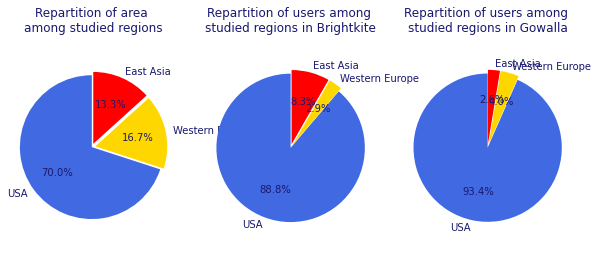

In [17]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig, ax = plt.subplots(1,3, figsize = (10, 4))


total_size = countries['land_area'].sum()
areas = countries['land_area'].to_list()
areas = [area*100/total_size for area in areas]
labels = ['USA', 'Western Europe', 'East Asia']
explode = (0, 0.05, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['royalblue', 'gold', 'r']
ax[0].pie(areas, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
        textprops=dict(color='midnightblue'))
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title("Repartition of area \namong studied regions", color = 'midnightblue')


total_users_b = len(homes_in_b)
users_b_areas = [len(homes_b_usa), len(homes_b_europe), len(homes_b_asia)]
users_b_areas = [nb*100/total_users_b for nb in users_b_areas]
ax[1].pie(users_b_areas, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
        textprops=dict(color='midnightblue'))
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title("Repartition of users among \nstudied regions in Brightkite", color = 'midnightblue')

total_users_g = len(homes_in_g)
users_g_areas = [len(homes_g_usa), len(homes_g_europe), len(homes_g_asia)]
users_g_areas = [nb*100/total_users_g for nb in users_g_areas]
ax[2].pie(users_g_areas, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
        textprops=dict(color='midnightblue'))
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title("Repartition of users among \nstudied regions in Gowalla", color = 'midnightblue')

plt.show()

In [18]:
homes_in_b.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_europe' : 'home_in_europe','is_in_asia' : 'home_in_asia',
                            'is_in_usa' : 'home_in_usa', 'cell_coord' : 'cell_home'}, inplace = True)

homes_in_g.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_europe' : 'home_in_europe','is_in_asia' : 'home_in_asia',
                            'is_in_usa' : 'home_in_usa', 'cell_coord' : 'cell_home'}, inplace = True)


In [19]:
b_checkins = pd.merge(b_checkins, homes_in_b, how = 'left', on = 'user')
g_checkins = pd.merge(g_checkins, homes_in_g, how = 'left', on = 'user')


In [20]:
b_checkins = b_checkins[b_checkins['cell_home'] != b_checkins['cell_coord']]
g_checkins = g_checkins[g_checkins['cell_home'] != g_checkins['cell_coord']]

KeyError: 'cell_coord'

In [66]:
b_checkins['dist_from_home'] = b_checkins.progress_apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)

g_checkins['dist_from_home'] = g_checkins.progress_apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)

100%|██████████| 2902101/2902101 [23:48<00:00, 2031.42it/s] 


In [21]:
b_checkins = pd.read_csv(data_folder + 'b_with_dist.txt.gz')
g_checkins = pd.read_csv(data_folder + 'g_with_dist.txt.gz')

In [22]:
# Function that computes the distributions of the values in data and plots it using a scatter plot.
# The arguments are:
#    - data: the array containing the values for which we want to compute the distribution.
#    - ax: the axes of the plot on shich we will apply the scatter function.
#    - marker, color, m_size: type, edgecolor and size of the markers we want. m_size is set to 120 by default.
#    - bins_max, num_bins: max value for the logspace function, and number of values wanted for the bins. 
#                          Defalut values set respectively to 10^5 and 100 for this plot.
def plot_probability(data, ax, marker, color, label, m_size = 120, bins_max = pow(10,5), num_bins = 100):
    log_bins=np.logspace(0, np.log10(bins_max), num = num_bins)
    hist_values, bins = np.histogram(data, bins= log_bins, density=True)
    ax.scatter(bins[:-1], hist_values, marker= marker, s=m_size, facecolors='none', edgecolors=color, label=label)

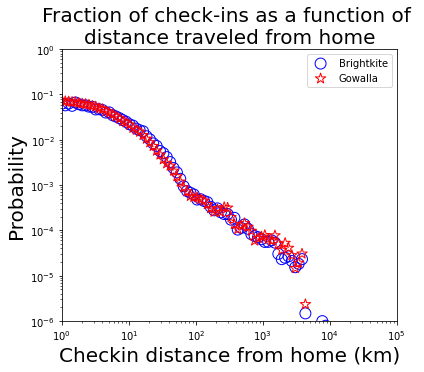

In [23]:
# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, ax = plt.subplots(figsize=(6, 5))

# BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
plot_probability(b_checkins['dist_from_home'], ax, 'o', 'b', 'Brightkite')

# GOWALLA – computing and scatter plotting the distribution of home distances between friends.
plot_probability(g_checkins['dist_from_home'], ax, '*', 'r', 'Gowalla')

# Setting the axes' scales to be logarithmic.
ax.set_xscale("log")
ax.set_yscale("log")

#Setting the limits of the axes to match the ones in the paper's plot.
ax.set_xlim(10e-1, 10e4)
ax.set_ylim(10e-7, 10e-1)

# Naming the axes and resizing the labels
ax.set_xlabel('Checkin distance from home (km)', size=20)
ax.set_ylabel('Probability', size=20)

# Adding the color legend and the title of the plot.
ax.set_title("Fraction of check-ins as a function of \ndistance traveled from home", size=20)
ax.legend()

In [24]:
b_checkins_asia = b_checkins[b_checkins['is_in_asia']]
b_checkins_europe = b_checkins[b_checkins['is_in_europe']]
b_checkins_usa = b_checkins[b_checkins['is_in_usa']]

g_checkins_asia = g_checkins[g_checkins['is_in_asia']]
g_checkins_europe = g_checkins[g_checkins['is_in_europe']]
g_checkins_usa = g_checkins[g_checkins['is_in_usa']]

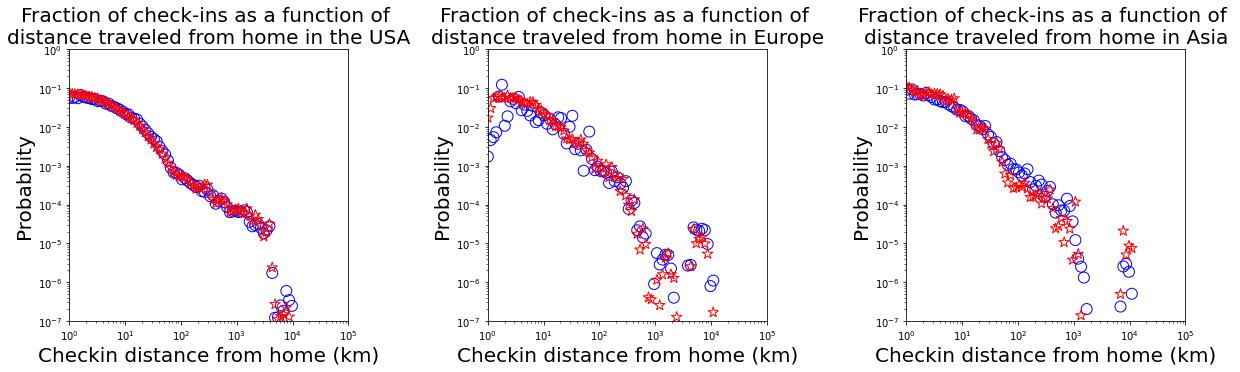

In [26]:
# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey = False, sharex = False)

# BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
plot_probability(b_checkins_usa['dist_from_home'], ax[0], 'o', 'b', 'Brightkite')

# GOWALLA – computing and scatter plotting the distribution of home distances between friends.
plot_probability(g_checkins_usa['dist_from_home'], ax[0], '*', 'r', 'Gowalla')


# BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
plot_probability(b_checkins_europe['dist_from_home'], ax[1], 'o', 'b', 'Brightkite')

# GOWALLA – computing and scatter plotting the distribution of home distances between friends.
plot_probability(g_checkins_europe['dist_from_home'], ax[1], '*', 'r', 'Gowalla')

# BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
plot_probability(b_checkins_asia['dist_from_home'], ax[2], 'o', 'b', 'Brightkite')

# GOWALLA – computing and scatter plotting the distribution of home distances between friends.
plot_probability(g_checkins_asia['dist_from_home'], ax[2], '*', 'r', 'Gowalla')


# Setting the axes' scales to be logarithmic.
ax[0].set_xscale("log")
ax[0].set_yscale("log")

ax[1].set_xscale("log")
ax[1].set_yscale("log")

ax[2].set_xscale("log")
ax[2].set_yscale("log")

#Setting the limits of the axes to match the ones in the paper's plot.
ax[0].set_xlim(10e-1, 10e4)
ax[0].set_ylim(10e-8, 10e-1)

ax[1].set_xlim(10e-1, 10e4)
ax[1].set_ylim(10e-8, 10e-1)

ax[2].set_xlim(10e-1, 10e4)
ax[2].set_ylim(10e-8, 10e-1)

# Naming the axes and resizing the labels
ax[0].set_xlabel('Checkin distance from home (km)', size=20)
ax[0].set_ylabel('Probability', size=20)
ax[1].set_xlabel('Checkin distance from home (km)', size=20)
ax[1].set_ylabel('Probability', size=20)
ax[2].set_xlabel('Checkin distance from home (km)', size=20)
ax[2].set_ylabel('Probability', size=20)

# Adding the color legend and the title of the plot.
ax[0].set_title("Fraction of check-ins as a function of \ndistance traveled from home in the USA", size=20)
ax[1].set_title("Fraction of check-ins as a function of \ndistance traveled from home in Europe", size=20)
ax[2].set_title("Fraction of check-ins as a function of \ndistance traveled from home in Asia", size=20)

plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
#ax[0].legend()

## TODO statistical test 

stat_test : - same distribution between continents in checkins distance
            - same distribution between events/normal year day in each continent in checkins distance

# Plot the distribution of how far people tend to travel from their home on the special dates and on each continent

In [27]:
b_checkins ['checkin_time'] = b_checkins['checkin_time'].progress_apply(lambda x : pd.to_datetime(x))
g_checkins ['checkin_time'] = g_checkins['checkin_time'].progress_apply(lambda x : pd.to_datetime(x))

100%|██████████| 2902101/2902101 [06:34<00:00, 7358.53it/s] 


In [28]:
events = pd.read_csv(data_folder+'events.csv', sep = ';')
events

,Unnamed: 0,Unnamed: 0.1,name,type,beginning,end,year
0,0,0,Christmas and New Year Eve,Religious and cultural event,2008-12-20,2009-01-02,2008
1,1,1,Christmas and New Year Eve,Religious and cultural event,2009-12-19,2010-01-02,2009
2,2,2,USA National Day,Cultural Event,2008-06-27,2008-07-07,2008
3,3,3,USA National Day,Cultural Event,2009-06-26,2009-07-06,2009
4,4,4,USA National Day,Cultural Event,2010-06-27,2010-07-07,2010
5,5,5,Winter Olympic Games,Major Sport Event,2010-02-12,2010-02-28,2010


In [29]:
events['beginning'] = events['beginning'].progress_apply(lambda x : pd.to_datetime(x, dayfirst = True))
events['end'] = events['end'].progress_apply(lambda x : pd.to_datetime(x, dayfirst = True))

100%|██████████| 6/6 [00:00<00:00, 499.08it/s]


In [30]:
events.to_csv(data_folder+'events.csv', sep = ';')
events

,Unnamed: 0,Unnamed: 0.1,name,type,beginning,end,year
0,0,0,Christmas and New Year Eve,Religious and cultural event,2008-12-20,2009-01-02,2008
1,1,1,Christmas and New Year Eve,Religious and cultural event,2009-12-19,2010-01-02,2009
2,2,2,USA National Day,Cultural Event,2008-06-27,2008-07-07,2008
3,3,3,USA National Day,Cultural Event,2009-06-26,2009-07-06,2009
4,4,4,USA National Day,Cultural Event,2010-06-27,2010-07-07,2010
5,5,5,Winter Olympic Games,Major Sport Event,2010-02-12,2010-02-28,2010


For each special event and each continent, we find how far from their home people tend to travel.

/Users/clemencebarsi/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


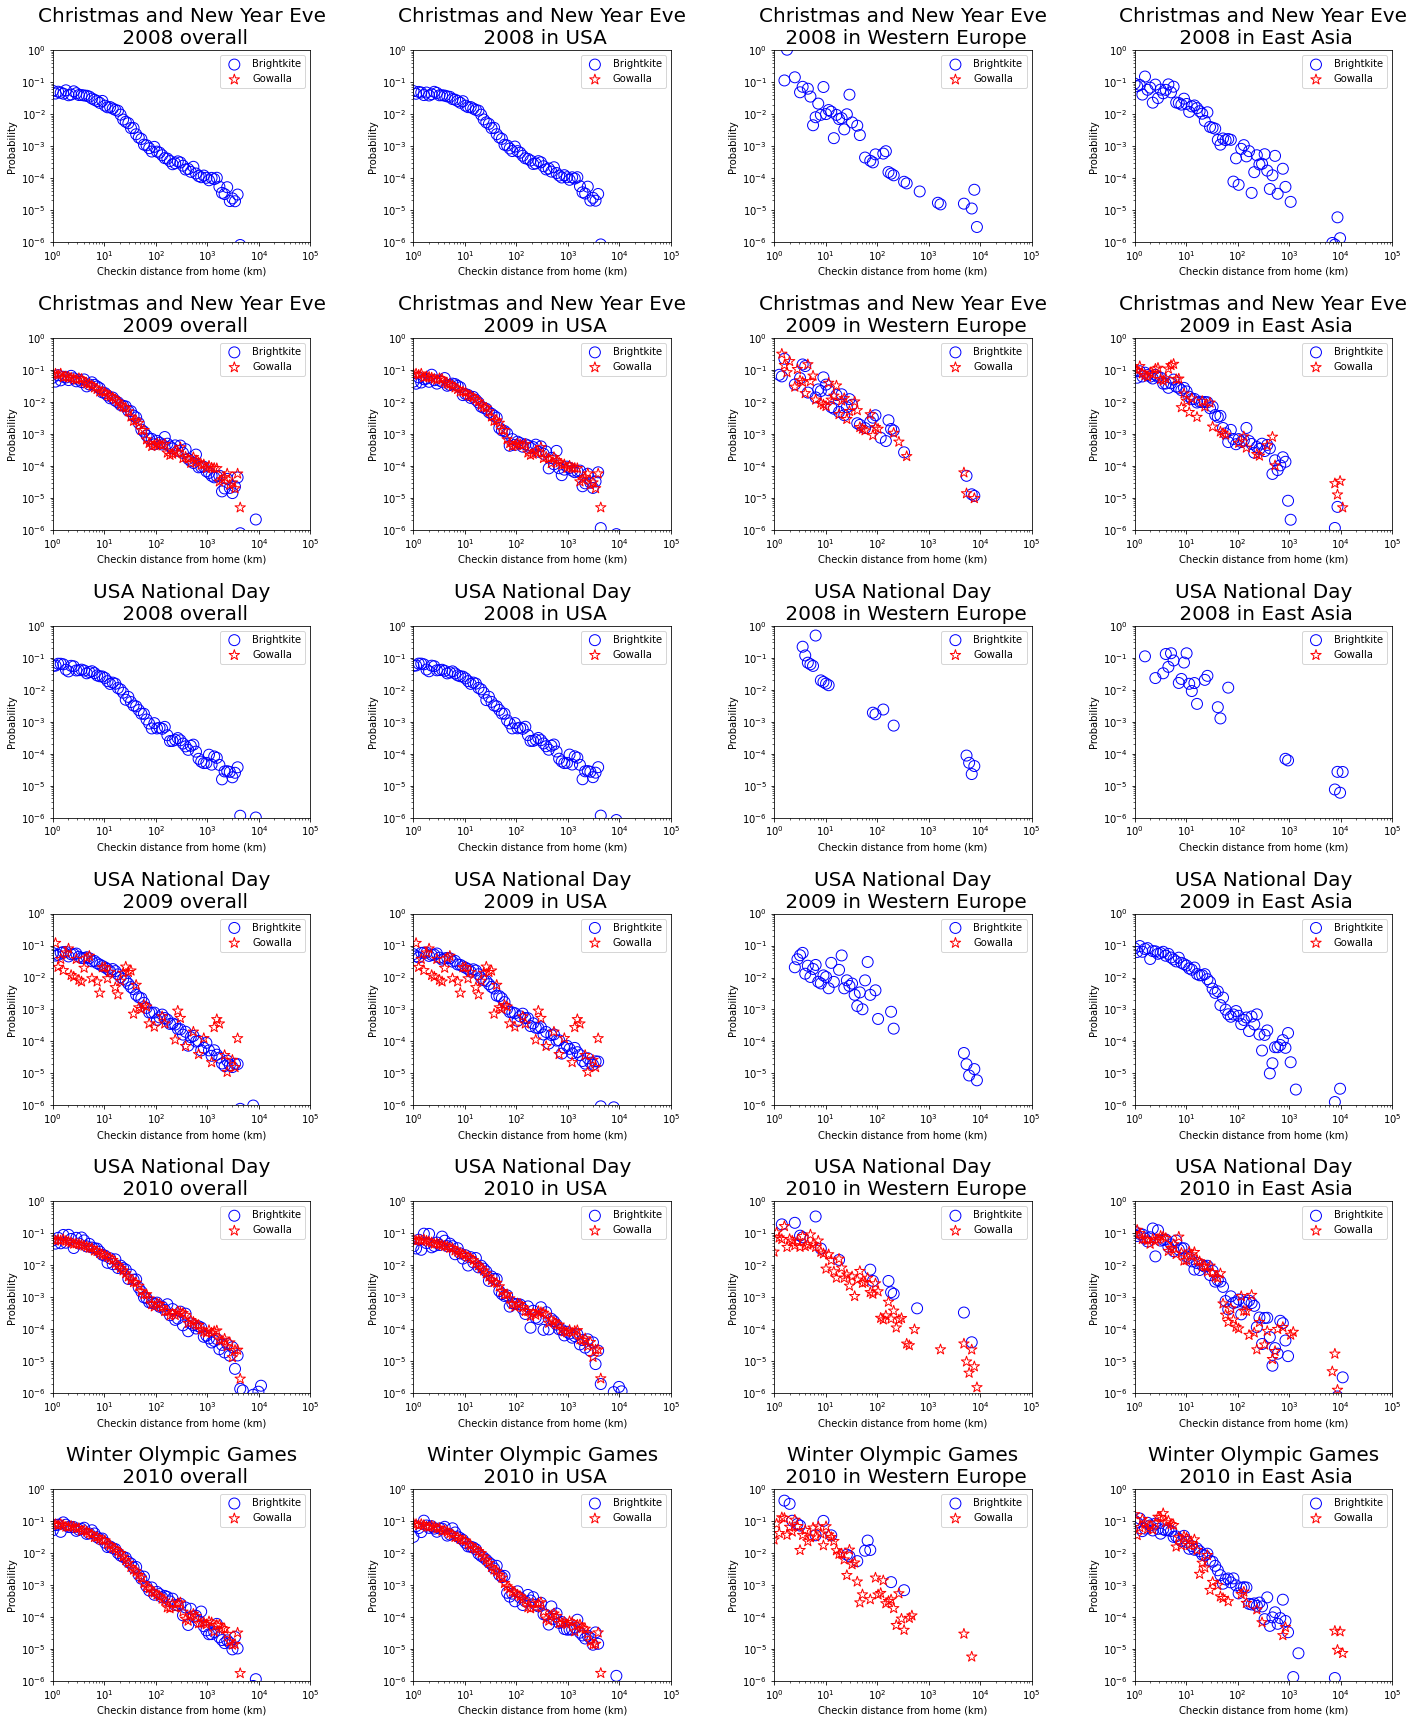

In [31]:
# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, axs = plt.subplots(6,4, figsize=(6*4, 5*6))
    
utc=pytz.UTC

end_titles = [' overall', ' in USA', ' in Western Europe', ' in East Asia']

for idx in events.index :
    #select only the ones in the correct timestamps 
    b_checkins_plot = b_checkins[(b_checkins.checkin_time <= utc.localize(events.iloc[idx]['end'])) &
                                         (b_checkins.checkin_time >= utc.localize(events.iloc[idx]['beginning']))]
    
    g_checkins_plot = g_checkins[(g_checkins.checkin_time <= utc.localize(events.iloc[idx]['end'])) &
                                         (g_checkins.checkin_time >= utc.localize(events.iloc[idx]['beginning']))]
    
    b_checkins_usa_plot = b_checkins[(b_checkins.is_in_usa) & (b_checkins.checkin_time <= utc.localize(events.iloc[idx]['end'])) &
                                         (b_checkins.checkin_time >= utc.localize(events.iloc[idx]['beginning']))]
    
    g_checkins_usa_plot = g_checkins[(g_checkins.is_in_usa) & (g_checkins.checkin_time <= utc.localize(events.iloc[idx]['end'])) &
                                         (g_checkins.checkin_time >= utc.localize(events.iloc[idx]['beginning']))]
    
    b_checkins_europe_plot = b_checkins[(b_checkins.is_in_europe) & (b_checkins.checkin_time <= utc.localize(events.iloc[idx]['end'])) &
                                         (b_checkins.checkin_time >= utc.localize(events.iloc[idx]['beginning']))]
    
    g_checkins_europe_plot = g_checkins[(g_checkins.is_in_europe) & (g_checkins.checkin_time <= utc.localize(events.iloc[idx]['end'])) &
                                         (g_checkins.checkin_time >= utc.localize(events.iloc[idx]['beginning']))]
    
    b_checkins_asia_plot = b_checkins[(b_checkins.is_in_asia) & (b_checkins.checkin_time <= utc.localize(events.iloc[idx]['end'])) &
                                         (b_checkins.checkin_time >= utc.localize(events.iloc[idx]['beginning']))]
    
    g_checkins_asia_plot = g_checkins[(g_checkins.is_in_asia) & (g_checkins.checkin_time <= utc.localize(events.iloc[idx]['end'])) &
                                         (g_checkins.checkin_time >= utc.localize(events.iloc[idx]['beginning']))]
    
    
    
    # BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(b_checkins_plot['dist_from_home'], axs[idx,0], 'o', 'blue', 'Brightkite')

    # GOWALLA – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(g_checkins_plot['dist_from_home'], axs[idx,0], '*', 'red', 'Gowalla')
    
     # BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(b_checkins_usa_plot['dist_from_home'], axs[idx,1], 'o', 'blue', 'Brightkite')

    # GOWALLA – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(g_checkins_usa_plot['dist_from_home'], axs[idx,1], '*', 'red', 'Gowalla')
    
     # BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(b_checkins_europe_plot['dist_from_home'], axs[idx,2], 'o', 'blue', 'Brightkite')

    # GOWALLA – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(g_checkins_europe_plot['dist_from_home'], axs[idx,2], '*', 'red', 'Gowalla')
    
     # BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(b_checkins_asia_plot['dist_from_home'], axs[idx,3], 'o', 'blue', 'Brightkite')

    # GOWALLA – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(g_checkins_asia_plot['dist_from_home'], axs[idx,3], '*', 'red', 'Gowalla')

    for i in range(4):
        # Setting the axes' scales to be logarithmic.
        axs[idx, i].set_xscale("log")
        axs[idx, i].set_yscale("log")

        #Setting the limits of the axes to match the ones in the paper's plot.
        axs[idx, i].set_xlim(10e-1, 10e4)
        axs[idx, i].set_ylim(10e-7, 10e-1)

        # Naming the axes and resizing the labels
        axs[idx, i].set_xlabel('Checkin distance from home (km)', size=10)
        axs[idx, i].set_ylabel('Probability', size=10)

        # Adding the color legend and the title of the plot.
        axs[idx, i].set_title(str(events.loc[idx]['name']) + '\n '+ str(events.loc[idx]['year']) + str(end_titles[i]), 
                                                                      size=20)
        axs[idx, i].legend()

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

## TODO plot average number of checkins per day overall and in each continent

In [32]:
#Adding a column with the date of each checkin
b_checkins['checkin_day'] = b_checkins['checkin_time'].progress_apply(lambda x : x.date())
g_checkins['checkin_day'] = g_checkins['checkin_time'].progress_apply(lambda x : x.date())

b_checkins['checkin_hour'] = b_checkins['checkin_time'].progress_apply(lambda x : x.time())
g_checkins['checkin_hour'] = g_checkins['checkin_time'].progress_apply(lambda x : x.time())

100%|██████████| 2902101/2902101 [00:26<00:00, 109461.38it/s]


In [38]:
b_checkins_usa = b_checkins[b_checkins['is_in_usa']]
b_checkins_europe = b_checkins[b_checkins['is_in_europe']]
b_checkins_asia = b_checkins[b_checkins['is_in_asia']]

g_checkins_usa = g_checkins[g_checkins['is_in_usa']]
g_checkins_europe = g_checkins[g_checkins['is_in_europe']]
g_checkins_asia = g_checkins[g_checkins['is_in_asia']]

In [39]:
def checkins_daily(checkins):
    checkins_daily = checkins.groupby('checkin_day').agg({'checkin_time':'count'}).reset_index()
    return checkins_daily.rename(columns = {'checkin_time' : 'checkin_count'})

In [41]:
dict_checkins_b = {'b_checkins': b_checkins, 'b_checkins_usa': b_checkins_usa, 
                   'b_checkins_europe': b_checkins_europe, 'b_checkins_asia': b_checkins_asia}
dict_checkins_g = {'g_checkins': g_checkins, 'g_checkins_usa': g_checkins_usa, 
                   'g_checkins_europe': g_checkins_europe, 'g_checkins_asia': g_checkins_asia}

dict_checkins = dict_checkins_b.copy()
dict_checkins.update(dict_checkins_g)
dict_checkins_daily = dict()

for df_name in dict_checkins.keys():
    dict_checkins_daily[df_name + '_daily'] = checkins_daily(dict_checkins[df_name])
    

#print(b_checkins_daily.head())
#dict_checkins_daily['b_checkins_asia_daily'].head()

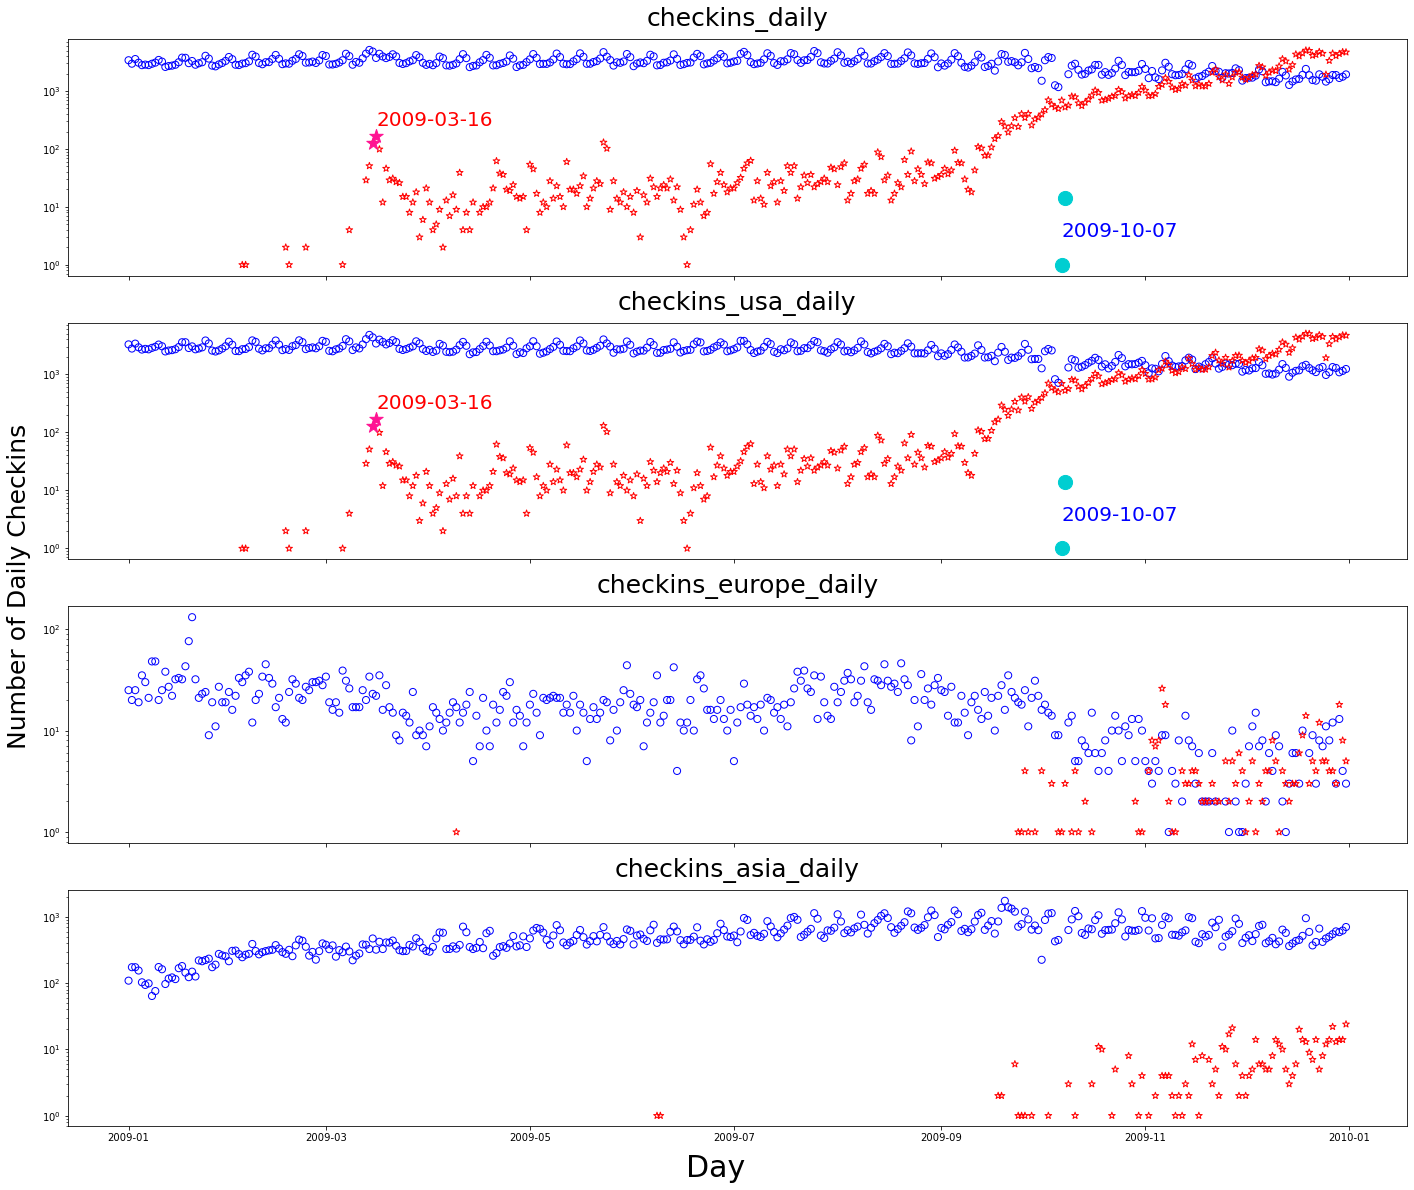

In [42]:
fig, axs = plt.subplots(4,1, figsize=(6*4, 20), sharex=True)

for i, (name, df) in enumerate(dict_checkins_b.items()):
     
    df_b = dict_checkins_daily[name+'_daily']
    df_b_2009 = df_b[df_b['checkin_day'].apply(lambda date: date.year == 2009)]
    df_g = dict_checkins_daily['g' + name[1:] +'_daily']
    df_g_2009 = df_g[df_g['checkin_day'].apply(lambda date: date.year == 2009)]
    axs[i].scatter(x=df_b_2009['checkin_day'], y=df_b_2009['checkin_count'], marker='o', 
                               label = 'Brightkite', s=50, facecolors='none', edgecolors='blue')
    axs[i].scatter(x=df_g_2009['checkin_day'], y=df_g_2009['checkin_count'], marker='*', 
                               label = 'Gowalla', s=50, facecolors='none', edgecolors='red')
    axs[i].set_title(name[2:]+'_daily', size=25, y=1.03)
    
    if(i<2):
        mystery_day = df_b_2009[df_b_2009['checkin_count'] < 15]
        axs[i].annotate(mystery_day.iloc[0]['checkin_day'], (mystery_day.iloc[0]['checkin_day'], 100),
                    xytext=(mystery_day.iloc[0]['checkin_day'], 3), color = 'b', size=20)
        axs[i].scatter(x=mystery_day.iloc[1]['checkin_day'], y=mystery_day.iloc[1]['checkin_count'], marker='o', 
                               label = 'Brightkite', s=200, color = 'darkturquoise')
        axs[i].scatter(x=mystery_day.iloc[0]['checkin_day'], y=mystery_day.iloc[0]['checkin_count'], marker='o', 
                               label = 'Brightkite', s=200, color = 'darkturquoise')
        mystery_day_2 = df_g_2009[(df_g_2009['checkin_count']>100) & (df_g_2009['checkin_day']<pd.to_datetime('2009-04'))]
        axs[i].annotate(mystery_day_2.iloc[1]['checkin_day'], (mystery_day_2.iloc[1]['checkin_day'], 100),
                    xytext=(mystery_day_2.iloc[1]['checkin_day'], 250), color = 'r', size=20)
        axs[i].scatter(x=mystery_day_2.iloc[0]['checkin_day'], y=mystery_day_2.iloc[0]['checkin_count'], marker='*', 
                               label = 'Gowalla', s=200, color = 'deeppink')
        axs[i].scatter(x=mystery_day_2.iloc[1]['checkin_day'], y=mystery_day_2.iloc[1]['checkin_count'], marker='*', 
                               label = 'Gowalla', s=200, color = 'deeppink')
    axs[i].set_yscale('log')
    
fig.text(0.5, 0.09, 'Day', ha='center', size=30)
fig.text(0.09, 0.5, 'Number of Daily Checkins', va='center', rotation='vertical', size=25)
plt.subplots_adjust(hspace = 0.2)

## TODO  plot average number of checkins per user in each continent

## TODO nbre de checkins autour des events in each continent

In [278]:
def filter_event_days(event, checkins):
    return checkins[(checkins.checkin_day <= utc.localize(event['end'])) &
                                         (checkins.checkin_day >= utc.localize(event['beginning']))]
    
dict_checkins_daily_events = dict()

def add_items_to_dict(df, df_name, dict_checkins = dict_checkins_daily_events, events = events):
    for idx, event in events.iterrows():
        dict_checkins[str(df_name)+'_'+ str(event['name'])] = filter_event_days(event, df)
    return dict_checkins

#for df_name, df in dict_checkins_daily.items():
 #   dict_checkins_daily_events = add_items_to_dict(df, df_name)

In [156]:
#dict_checkins_daily_events['b_checkins_daily_Christmas and New Year Eve'].head()
dict_checkins_daily_events.keys()
#len(dict_checkins_daily_events)

dict_keys(['b_checkins_daily_Christmas and New Year Eve', 'b_checkins_daily_USA National Day', 'b_checkins_daily_Winter Olympic Games', 'b_checkins_usa_daily_Christmas and New Year Eve', 'b_checkins_usa_daily_USA National Day', 'b_checkins_usa_daily_Winter Olympic Games', 'b_checkins_europe_daily_Christmas and New Year Eve', 'b_checkins_europe_daily_USA National Day', 'b_checkins_europe_daily_Winter Olympic Games', 'b_checkins_asia_daily_Christmas and New Year Eve', 'b_checkins_asia_daily_USA National Day', 'b_checkins_asia_daily_Winter Olympic Games', 'g_checkins_daily_Christmas and New Year Eve', 'g_checkins_daily_USA National Day', 'g_checkins_daily_Winter Olympic Games', 'g_checkins_usa_daily_Christmas and New Year Eve', 'g_checkins_usa_daily_USA National Day', 'g_checkins_usa_daily_Winter Olympic Games', 'g_checkins_europe_daily_Christmas and New Year Eve', 'g_checkins_europe_daily_USA National Day', 'g_checkins_europe_daily_Winter Olympic Games', 'g_checkins_asia_daily_Christmas 

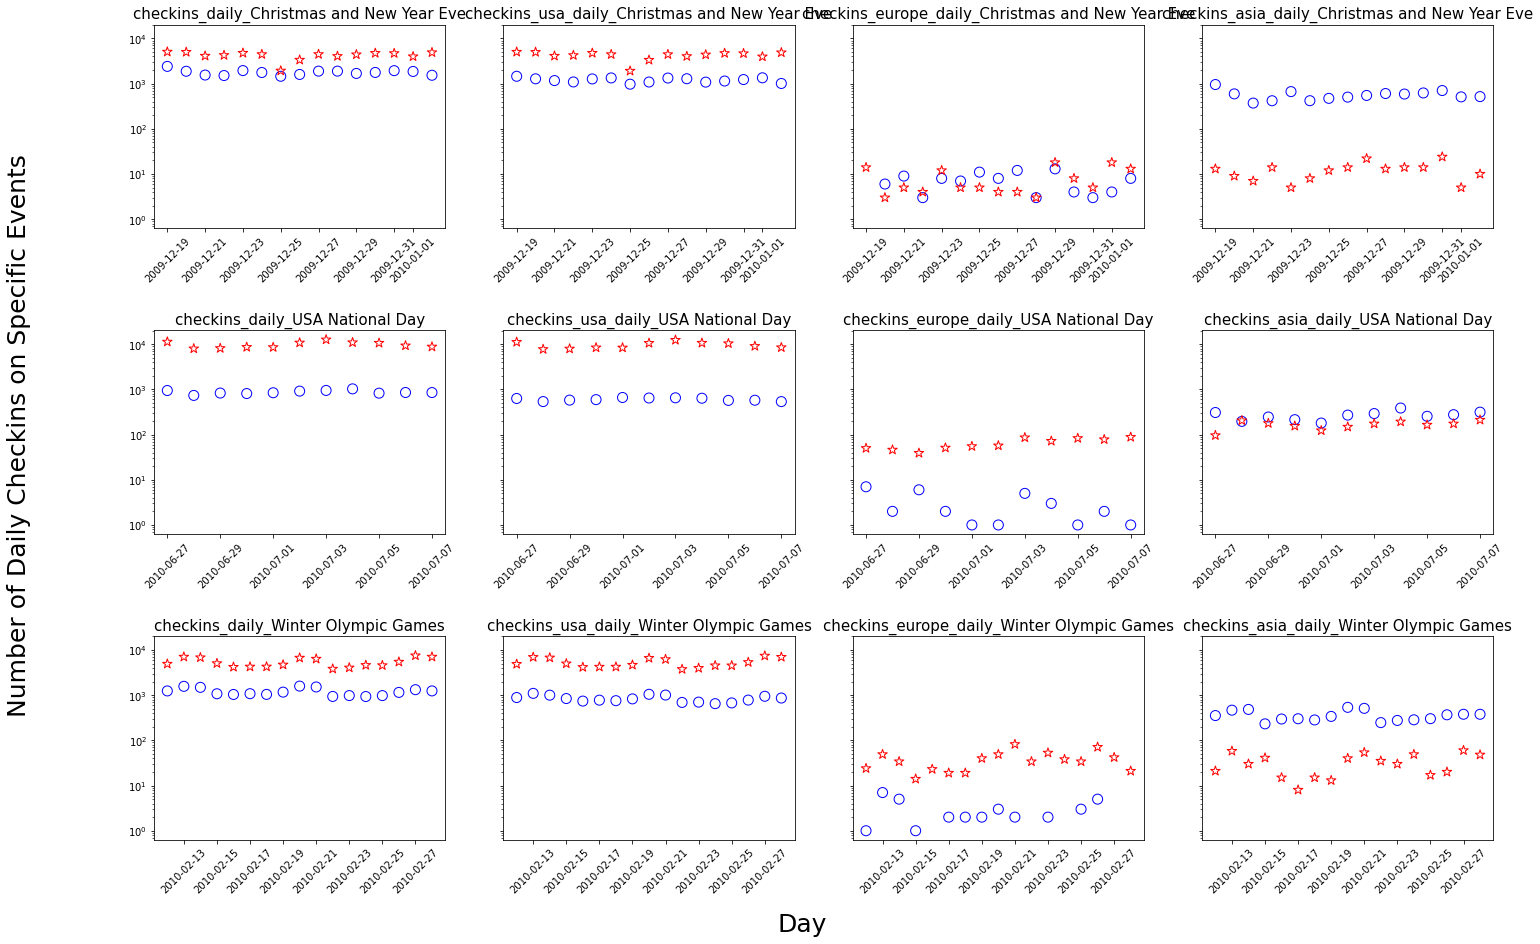

In [45]:
fig, axs = plt.subplots(3,4, figsize=(6*4, 3*5), sharey=True)

for i, (name, df) in enumerate(dict_checkins_daily_events.items()):
     
    if(i<12):
        axs[i%3, i//3].scatter(x=df['checkin_day'], y=df['checkin_count'],marker='o', 
                               label = 'Brightkite', s=100, facecolors='none', edgecolors='blue')
        axs[i%3, i//3].set_title(name[2:], size=15)
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[i%3, i//4],bins = len(df), label = 'Brightkite', color='blue')
    else:
        j = i-12
        axs[j%3, j//3].scatter(x=df['checkin_day'], y=df['checkin_count'],marker='*', 
                               label = 'Gowalla', s=100, facecolors='none', edgecolors='red')
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[j%3, j//4],bins = len(df), label = 'Gowalla', color = 'red'
        plt.setp(axs[j%3, j//3].get_xticklabels(), Rotation=45)
        axs[j%3, j//3].set_yscale('log')
        

fig.text(0.5, 0.04, 'Day', ha='center', size=25)
fig.text(0.04, 0.5, 'Number of Daily Checkins on Specific Events', va='center', rotation='vertical', size=25)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)



In [46]:
def filter_dict(dict, callback_fucn):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if callback((key, value)):
            newDict[key] = value
    return newDict

dict_checkins_USA_daily_events = dict(filter(lambda elem: 'usa' in elem[0], dict_checkins_daily_events.items()))

dict_checkins_USA_daily_events.keys()

dict_keys(['b_checkins_usa_daily_Christmas and New Year Eve', 'b_checkins_usa_daily_USA National Day', 'b_checkins_usa_daily_Winter Olympic Games', 'g_checkins_usa_daily_Christmas and New Year Eve', 'g_checkins_usa_daily_USA National Day', 'g_checkins_usa_daily_Winter Olympic Games'])

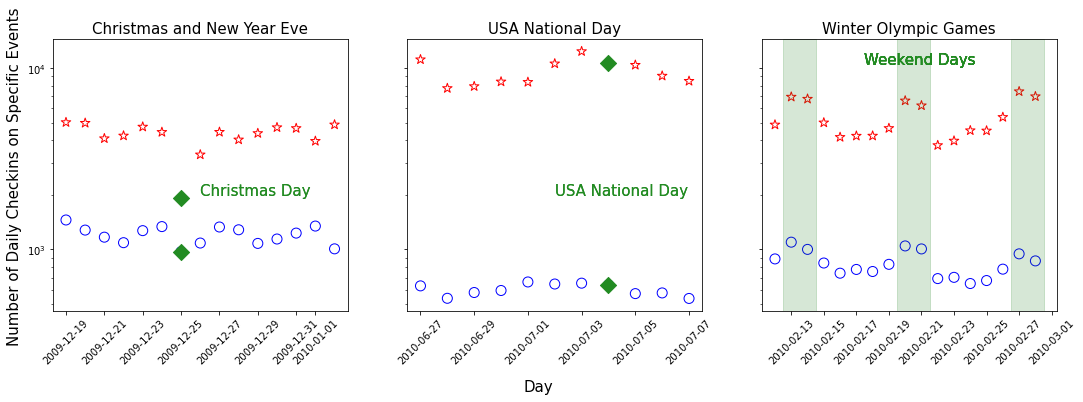

In [105]:
fig, axs = plt.subplots(1,3, figsize=(6*3, 5), sharey=True)

for i, (name, df) in enumerate(dict_checkins_USA_daily_events.items()):
     
    if(i<3):
        axs[i].scatter(x=df['checkin_day'], y=df['checkin_count'],marker='o', 
                               label = 'Brightkite', s=100, facecolors='none', edgecolors='blue')
        axs[i].set_title(name[21:], size=15)
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[i%3, i//4],bins = len(df), label = 'Brightkite', color='blue')
    else:
        j = i-3
        axs[j].scatter(x=df['checkin_day'], y=df['checkin_count'],marker='*', 
                               label = 'Gowalla', s=100, facecolors='none', edgecolors='red')
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[j%3, j//4],bins = len(df), label = 'Gowalla', color = 'red'
        plt.setp(axs[j].get_xticklabels(), Rotation=45)
        axs[j].set_yscale('log')
    if(i%3==0):
        xmas_day= pd.to_datetime('2009-12-25')
        xmas_text= pd.to_datetime('2009-12-26')
        xmas_count= df[df['checkin_day'] == xmas_day]['checkin_count']
        axs[0].annotate('Christmas Day', (xmas_day, xmas_count),
                   xytext=(xmas_text, 2000), color = 'forestgreen', size=15)
        axs[0].scatter(x=xmas_day, y=xmas_count, marker='D', s=130, color = 'forestgreen')
    if(i%3==1):
        usa_day= pd.to_datetime('2010-07-04')
        usa_text= pd.to_datetime('2010-07-02')
        usa_count= df[df['checkin_day'] == usa_day]['checkin_count']
        axs[1].annotate('USA National Day', (usa_day, usa_count),
                   xytext=(usa_text, 2000), color = 'forestgreen', size=15)
        axs[1].scatter(x=usa_day, y=usa_count, marker='D', s=130, color = 'forestgreen')
    
    we_day = pd.to_datetime('2010-02-12 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-14 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-19 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-21 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-26 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-28 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-19 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-21 12:00:00')
    we_text = pd.to_datetime('2010-02-17 12:00:00')
    #we_count = df[df['checkin_day']== we_text]['checkin_count']
    axs[2].annotate('Weekend Days', (we_day, 10500),
                   xytext=(we_text, 10500), color = 'forestgreen', size=15)
    
fig.text(0.5, -0.1, 'Day', ha='center', size=15)
fig.text(0.09, 0.5, 'Number of Daily Checkins on Specific Events', va='center', rotation='vertical', size=15)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)



In [307]:
#b_start_date = b_checkins['checkin_time'].min()
#b_end_date = b_checkins['checkin_time'].max()

start_date = np.max([g_checkins['checkin_time'].min(), b_checkins['checkin_time'].min()])
end_date = np.min([g_checkins['checkin_time'].max(), b_checkins['checkin_time'].max()])

def create_random_dates(start_date, end_date, nbOfDays):
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days
    random_number_of_days = random.randrange(days_between_dates)
    random_date_start = start_date + datetime.timedelta(days=random_number_of_days)
    random_date_start = pd.to_datetime(random_date_start).date()
    random_date_end = pd.to_datetime(random_date_start + datetime.timedelta(days= nbOfDays))
    return (random_date_start, random_date_end)




In [369]:
xmas_rdm_dates = create_random_dates(start_date, end_date, 14)
usa_day_rdm_dates = create_random_dates(start_date, end_date, 10)
olympics_rdm_dates = create_random_dates(start_date, end_date, 16)

In [370]:
events = pd.read_csv(data_folder +'events.csv', sep = ';')

In [371]:
events = events[events['type'] != 'Random']

In [372]:
events = events.append({'name' :'xmas_random', 'beginning': xmas_rdm_dates[0], 'end' : xmas_rdm_dates[1], 
               'year' : xmas_rdm_dates[0].year,'type' :'Random'},ignore_index = True)
events = events.append({'name' :'usa_day_random', 'beginning': usa_day_rdm_dates[0], 'end' : usa_day_rdm_dates[1], 
               'year' : usa_day_rdm_dates[0].year,'type' :'Random'},ignore_index = True)
events = events.append({'name' :'olympics_random', 'beginning': olympics_rdm_dates[0], 'end' : olympics_rdm_dates[1], 
               'year' : olympics_rdm_dates[0].year,'type' :'Random'},ignore_index = True)
events

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,name,type,beginning,end,year
0,0.0,0.0,0.0,Christmas and New Year Eve,Religious and cultural event,2008-12-20,2009-01-02,2008
1,1.0,1.0,1.0,Christmas and New Year Eve,Religious and cultural event,2009-12-19,2010-01-02,2009
2,2.0,2.0,2.0,USA National Day,Cultural Event,2008-06-27,2008-07-07,2008
3,3.0,3.0,3.0,USA National Day,Cultural Event,2009-06-26,2009-07-06,2009
4,4.0,4.0,4.0,USA National Day,Cultural Event,2010-06-27,2010-07-07,2010
5,5.0,5.0,5.0,Winter Olympic Games,Major Sport Event,2010-02-12,2010-02-28,2010
6,NaN,NaN,NaN,xmas_random,Random,2010-09-10,2010-09-24 00:00:00,2010
7,NaN,NaN,NaN,usa_day_random,Random,2010-04-08,2010-04-18 00:00:00,2010
8,NaN,NaN,NaN,olympics_random,Random,2009-10-01,2009-10-17 00:00:00,2009


In [373]:
events['beginning'] = events['beginning'].progress_apply(lambda x : pd.to_datetime(x))
events['end'] = events['end'].progress_apply(lambda x : pd.to_datetime(x))

100%|██████████| 9/9 [00:00<00:00, 1585.02it/s]


### Conclusion 

We see that the proportion of checkins made in the USA is so big compared to the other countries, that it completely overtakes all variations of checkins in other places.
Hence, we will continue to analyse movements, but only in the USA.

## TODO nber of checkins arount each event in function of the nber of friends

In [128]:
nber_friends_b = b_edges.groupby('user').agg({'friend' : 'count'}).reset_index()
nber_friends_b.rename(columns = {'friend': 'friend_count'}, inplace = True)
nber_friends_g = g_edges.groupby('user').agg({'friend' : 'count'}).reset_index()
nber_friends_g.rename(columns = {'friend': 'friend_count'}, inplace = True)

In [129]:
b_checkins = pd.merge(b_checkins, nber_friends_b, on = 'user', how = 'left')
g_checkins = pd.merge(g_checkins, nber_friends_g, on = 'user', how = 'left')

In [157]:
dict_checkins_usa = dict()

dict_checkins_usa = add_items_to_dict(b_checkins_usa, 'b_checkins_usa', dict_checkins_usa)
dict_checkins_usa = add_items_to_dict(g_checkins_usa, 'g_checkins_usa', dict_checkins_usa)


In [374]:
dict_checkins_random = dict()

dict_checkins_random = add_items_to_dict(b_checkins_usa, 'b_checkins_usa', dict_checkins_random,
                                         events[events['type']=='Random'])
dict_checkins_random = add_items_to_dict(g_checkins_usa, 'g_checkins_usa', dict_checkins_random,
                                         events[events['type']=='Random'])
dict_checkins_random.keys()

dict_keys(['b_checkins_usa_xmas_random', 'b_checkins_usa_usa_day_random', 'b_checkins_usa_olympics_random', 'g_checkins_usa_xmas_random', 'g_checkins_usa_usa_day_random', 'g_checkins_usa_olympics_random'])

In [224]:
dict_checkins = add_items_to_dict(b_checkins, 'b_checkins', dict_checkins)
dict_checkins = add_items_to_dict(b_checkins, 'g_checkins', dict_checkins)

In [225]:
dict_checkins.keys()

dict_keys(['b_checkins', 'b_checkins_usa', 'b_checkins_europe', 'b_checkins_asia', 'g_checkins', 'g_checkins_usa', 'g_checkins_europe', 'g_checkins_asia', 'b_checkins__Christmas and New Year Eve', 'b_checkins__USA National Day', 'b_checkins__Winter Olympic Games', 'g_checkins__Christmas and New Year Eve', 'g_checkins__USA National Day', 'g_checkins__Winter Olympic Games', 'b_checkins_Christmas and New Year Eve', 'b_checkins_USA National Day', 'b_checkins_Winter Olympic Games', 'g_checkins_Christmas and New Year Eve', 'g_checkins_USA National Day', 'g_checkins_Winter Olympic Games'])

In [216]:
dict_checkins_events = dict()

dict_checkins_events['b_checkins_daily_Christmas and New Year Eve'] = dict_checkins_daily_events['b_checkins_daily_Christmas and New Year Eve']
dict_checkins_events['b_checkins_daily_USA National Day'] = dict_checkins_daily_events['b_checkins_daily_USA National Day']
dict_checkins_events['b_checkins_daily_Winter Olympic Games'] = dict_checkins_daily_events['b_checkins_daily_Winter Olympic Games']

dict_checkins_events['g_checkins_daily_Christmas and New Year Eve'] = dict_checkins_daily_events['g_checkins_daily_Christmas and New Year Eve']
dict_checkins_events['g_checkins_daily_USA National Day'] = dict_checkins_daily_events['g_checkins_daily_USA National Day']
dict_checkins_events['g_checkins_daily_Winter Olympic Games'] = dict_checkins_daily_events['g_checkins_daily_Winter Olympic Games']

In [183]:
dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve'] = pd.merge(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve'],
                                                                         nber_friends_b, on = 'user', how = 'left')

## Statistical tests

In [238]:
#P_value of different statistical tests

def p_value_hypothesis(name_1, name_2, p_value):
    if (p_value<0.05):
        print(p_value)
        print('We reject the hypothesis that the distribution of ' + name_1 + ' and ' + name_2 + ' are the same')
    else :
        print(p_value)
        print('We accept the hypothesis that the distribution of ' + name_1 + ' and ' + name_2 + ' are the same')

In [239]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins_usa['b_checkins_usa_USA National Day']['count']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['count']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_usa_Winter Olympic Games', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_USA National Day']['count']), 
                               np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['count']))
p_value_hypothesis('b_checkins_usa_USA National Day', 'b_checkins_usa_Winter Olympic Games', p_value)


1.5536933039464892e-107
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_usa_USA National Day are the same
1.0273267894913267e-16
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_usa_Winter Olympic Games are the same
3.1670300379341633e-55
We reject the hypothesis that the distribution of b_checkins_usa_USA National Day and b_checkins_usa_Winter Olympic Games are the same


In [240]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins_usa['g_checkins_usa_USA National Day']['count']))
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['count']))
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_usa_Winter Olympic Games', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_USA National Day']['count']), 
                               np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['count']))
p_value_hypothesis('g_checkins_usa_USA National Day', 'g_checkins_usa_Winter Olympic Games', p_value)


0.0
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_usa_USA National Day are the same
5.831085278245717e-127
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_usa_Winter Olympic Games are the same
5.655984945654147e-182
We reject the hypothesis that the distribution of g_checkins_usa_USA National Day and g_checkins_usa_Winter Olympic Games are the same


In [241]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins['b_checkins_Christmas and New Year Eve']['checkin_count']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_Christmas and New Year Eve', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins['b_checkins_USA National Day']['checkin_count']), 
                               np.array(dict_checkins_usa['b_checkins_usa_USA National Day']['count']))
p_value_hypothesis('b_checkins_USA National Day', 'b_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['count']), 
                               np.array(dict_checkins['b_checkins_Winter Olympic Games']['checkin_count']))
p_value_hypothesis('b_checkins_usa_Winter Olympic Games', 'b_checkins_Winter Olympic Games', p_value)

1.4080813869807548e-17
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_Christmas and New Year Eve are the same
1.0030772531010265e-14
We reject the hypothesis that the distribution of b_checkins_USA National Day and b_checkins_usa_USA National Day are the same
5.156119368049745e-18
We reject the hypothesis that the distribution of b_checkins_usa_Winter Olympic Games and b_checkins_Winter Olympic Games are the same


In [243]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(dict_checkins['g_checkins_Christmas and New Year Eve']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_Christmas and New Year Eve', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins['g_checkins_USA National Day']['dist_from_home']), 
                               np.array(dict_checkins_usa['g_checkins_usa_USA National Day']['dist_from_home']))
p_value_hypothesis('g_checkins_USA National Day', 'g_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(dict_checkins['g_checkins_Winter Olympic Games']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_Winter Olympic Games', 'g_checkins_Winter Olympic Games', p_value)

3.866395421647998e-29
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_Christmas and New Year Eve are the same
1.4135702596106622e-15
We reject the hypothesis that the distribution of g_checkins_USA National Day and g_checkins_usa_USA National Day are the same
4.036665286651846e-26
We reject the hypothesis that the distribution of g_checkins_usa_Winter Olympic Games and g_checkins_Winter Olympic Games are the same


In [248]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(b_checkins_usa['dist_from_home']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_usa', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins['b_checkins_USA National Day']['dist_from_home']), 
                               np.array(b_checkins_usa['dist_from_home']))
p_value_hypothesis('b_checkins_USA National Day', 'b_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(b_checkins_usa['dist_from_home']))
p_value_hypothesis('b_checkins_usa_Winter Olympic Games', 'b_checkins_Winter Olympic Games', p_value)

4.387421369292471e-110
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_Christmas and New Year Eve are the same
0.022851261222837854
We reject the hypothesis that the distribution of b_checkins_USA National Day and b_checkins_usa_USA National Day are the same
2.419014217686683e-06
We reject the hypothesis that the distribution of b_checkins_usa_Winter Olympic Games and b_checkins_Winter Olympic Games are the same


In [247]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(g_checkins_usa['dist_from_home']), equal_var = False)
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_Christmas and New Year Eve', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins['g_checkins_USA National Day']['dist_from_home']), 
                               np.array(g_checkins_usa['dist_from_home']), equal_var = False)
p_value_hypothesis('g_checkins_USA National Day', 'g_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(g_checkins_usa['dist_from_home']), equal_var = False)
p_value_hypothesis('g_checkins_usa_Winter Olympic Games', 'g_checkins_Winter Olympic Games', p_value)

7.308089053037219e-121
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_Christmas and New Year Eve are the same
3.3736279286014072e-06
We reject the hypothesis that the distribution of g_checkins_USA National Day and g_checkins_usa_USA National Day are the same
5.688111031788713e-88
We reject the hypothesis that the distribution of g_checkins_usa_Winter Olympic Games and g_checkins_Winter Olympic Games are the same


In [284]:
dict_checkins_random.keys()

dict_keys(['b_checkins_usa_xmas_random', 'b_checkins_usa_usa_day_random', 'b_checkins_usa_olympics_random', 'g_checkins_usa_xmas_random', 'g_checkins_usa_usa_day_random', 'g_checkins_usa_olympics_random'])

In [385]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(dict_checkins_random['b_checkins_usa_xmas_random']['dist_from_home']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_usa_xmas_random', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_USA National Day']['dist_from_home']), 
                               np.array(dict_checkins_random['b_checkins_usa_usa_day_random']['dist_from_home']))
p_value_hypothesis('b_checkins_usa_usa_day_random', 'b_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(dict_checkins_random['b_checkins_usa_olympics_random']['dist_from_home']))
p_value_hypothesis('b_checkins_usa_Winter Olympic Games', 'b_checkins_usa_olympics_random', p_value)

3.4634794377993845e-09
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_usa_xmas_random are the same
3.5486828104411703e-08
We reject the hypothesis that the distribution of b_checkins_usa_usa_day_random and b_checkins_usa_USA National Day are the same
0.005237268655486418
We reject the hypothesis that the distribution of b_checkins_usa_Winter Olympic Games and b_checkins_usa_olympics_random are the same


In [384]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(dict_checkins_random['g_checkins_usa_xmas_random']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_usa_xmas_random', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_USA National Day']['dist_from_home']), 
                               np.array(dict_checkins_random['g_checkins_usa_usa_day_random']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_usa_day_random', 'g_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(dict_checkins_random['g_checkins_usa_olympics_random']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_Winter Olympic Games', 'g_checkins_usa_olympics_random', p_value)

1.9335567057686826e-138
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_usa_xmas_random are the same
1.1890713390255975e-70
We reject the hypothesis that the distribution of g_checkins_usa_usa_day_random and g_checkins_usa_USA National Day are the same
8.840861705097052e-10
We reject the hypothesis that the distribution of g_checkins_usa_Winter Olympic Games and g_checkins_usa_olympics_random are the same


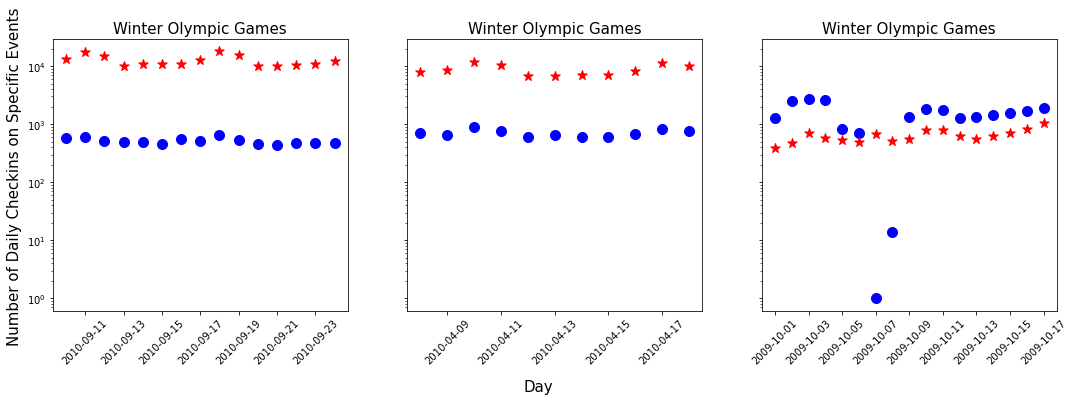

In [383]:
fig, axs = plt.subplots(1,3, figsize=(6*3, 5), sharey=True)

for i_rd, (name_rd, df_rd) in enumerate(dict_checkins_random.items()) :
    df_rd = df_rd.groupby(['checkin_day']).agg({'count':'count'}).reset_index()
    if(i_rd<3):
        axs[i_rd].scatter(x=df_rd['checkin_day'], y=df_rd['count'],marker='o', 
                             label = 'Brightkite', s=100, color = 'blue')
        axs[i_rd].set_title(name[21:], size=15)
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[i%3, i//4],bins = len(df), label = 'Brightkite', color='blue')
    else:
        j_rd = i_rd-3
        axs[j_rd].scatter(x=df_rd['checkin_day'], y=df_rd['count'],marker='*', 
                              label = 'Gowalla', s=100, color = 'red')
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[j%3, j//4],bins = len(df), label = 'Gowalla', color = 'red'
        plt.setp(axs[j_rd].get_xticklabels(), Rotation=45)
        axs[j_rd].set_yscale('log')

        
fig.text(0.5, -0.1, 'Day', ha='center', size=15)
fig.text(0.09, 0.5, 'Number of Daily Checkins on Specific Events', va='center', rotation='vertical', size=15)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)


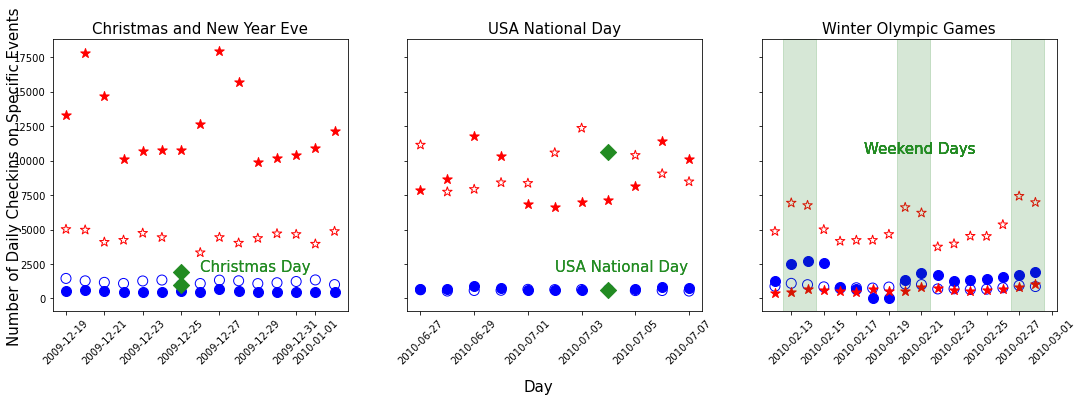

In [387]:
fig, axs = plt.subplots(1,3, figsize=(6*3, 5), sharey=True)

for ((i_rd, (name_rd, df_rd)), (i, (name, df))) in zip(enumerate(dict_checkins_random.items()),enumerate(dict_checkins_USA_daily_events.items())) :
    df_rd = df_rd.groupby(['checkin_day']).agg({'count':'count'}).reset_index()
    if(i_rd<3):
        axs[i_rd].scatter(x=df['checkin_day'], y=df_rd['count'],marker='o', 
                             label = 'Brightkite', s=100, color = 'blue')
        axs[i_rd].set_title(name[21:], size=15)
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[i%3, i//4],bins = len(df), label = 'Brightkite', color='blue')
    else:
        j_rd = i_rd-3
        axs[j_rd].scatter(x=df['checkin_day'], y=df_rd['count'],marker='*', 
                              label = 'Gowalla', s=100, color = 'red')
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[j%3, j//4],bins = len(df), label = 'Gowalla', color = 'red'
        plt.setp(axs[j_rd].get_xticklabels(), Rotation=45)
        #axs[j_rd].set_yscale('log')
    
    if(i<3):
        axs[i].scatter(x=df['checkin_day'], y=df['checkin_count'],marker='o', 
                               label = 'Brightkite', s=100, facecolors='none', edgecolors='blue')
        axs[i].set_title(name[21:], size=15)
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[i%3, i//4],bins = len(df), label = 'Brightkite', color='blue')
    else:
        j = i-3
        axs[j].scatter(x=df['checkin_day'], y=df['checkin_count'],marker='*', 
                               label = 'Gowalla', s=100, facecolors='none', edgecolors='red')
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[j%3, j//4],bins = len(df), label = 'Gowalla', color = 'red'
        plt.setp(axs[j].get_xticklabels(), Rotation=45)
        #axs[j].set_yscale('log')
    if(i%3==0):
        xmas_day= pd.to_datetime('2009-12-25')
        xmas_text= pd.to_datetime('2009-12-26')
        xmas_count= df[df['checkin_day'] == xmas_day]['checkin_count']
        axs[0].annotate('Christmas Day', (xmas_day, xmas_count),
                   xytext=(xmas_text, 2000), color = 'forestgreen', size=15)
        axs[0].scatter(x=xmas_day, y=xmas_count, marker='D', s=130, color = 'forestgreen')
    if(i%3==1):
        usa_day= pd.to_datetime('2010-07-04')
        usa_text= pd.to_datetime('2010-07-02')
        usa_count= df[df['checkin_day'] == usa_day]['checkin_count']
        axs[1].annotate('USA National Day', (usa_day, usa_count),
                   xytext=(usa_text, 2000), color = 'forestgreen', size=15)
        axs[1].scatter(x=usa_day, y=usa_count, marker='D', s=130, color = 'forestgreen')
    
    we_day = pd.to_datetime('2010-02-12 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-14 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-19 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-21 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-26 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-28 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-19 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-21 12:00:00')
    we_text = pd.to_datetime('2010-02-17 12:00:00')
    #we_count = df[df['checkin_day']== we_text]['checkin_count']
    axs[2].annotate('Weekend Days', (we_day, 10500),
                   xytext=(we_text, 10500), color = 'forestgreen', size=15)
        


    
fig.text(0.5, -0.1, 'Day', ha='center', size=15)
fig.text(0.09, 0.5, 'Number of Daily Checkins on Specific Events', va='center', rotation='vertical', size=15)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)


## OPT filter by top_user